In [21]:
"""

事前インストール(後でDockerfileに記載する。)
# conda install -c conda-forge tablua-py PyPDF2 -y

"""
import urllib.request
from abc import ABC
from abc import abstractmethod

import pandas as pd
import PyPDF2
import tabula
from IPython.display import display
import japanize_matplotlib

# 新型コロナウイルス陽性者数(チャーター便帰国者を除く)とPCR検査【1/15～4/4】 (厚生労働省データ(4/5付け)
URL_OF_PDF_FILE_WITH_CHECKUP_NUMBER_WITH_PREFECTURE = (
    "https://www.mhlw.go.jp/content/10906000/000619077.pdf"
)

# 国内における新型コロナウイルスに係るPCR検査の実施状況（結果判明日ベース）
URL_OF_PDF_FILE_WITH_PCR_TEST_NUMBER_WITH_ASSOCIATION_IN_JAPAN = (
    "https://www.mhlw.go.jp/content/10906000/000619078.pdf"
)
# これらのPDFの最新版は毎日更新される。
# リンクはこの辺のページに存在する。(https://www.mhlw.go.jp/stf/seisakunitsuite/bunya/0000164708_00001.html#kokunaihassei)

COUNT_OF_PREFECTURES = 47


def main():
    """main."""
    test_checkup()
    test_ctr()


def test_ctr():
    """test_ctr."""
    ctr_association = TestNumberWithAssociation(
        URL_OF_PDF_FILE_WITH_PCR_TEST_NUMBER_WITH_ASSOCIATION_IN_JAPAN
    )
    print("全検査数")
    display(ctr_association.get_data()[0])
    print("保険適応検査数")
    display(ctr_association.get_data()[1])


def test_checkup():
    """test_checkup."""
    checkups_with_pref = CheckupNumberWithPref(
        url_s=URL_OF_PDF_FILE_WITH_CHECKUP_NUMBER_WITH_PREFECTURE
    )
    # 陽性者数
    display(checkups_with_pref.get_data())


class PDF(ABC):
    """PDF."""

    def __init__(self, url_s: str, file_dir_s="./../data/raw/"):
        """__init__.

        :param url_s:
        pdfファイルのURLを入力します。
        :type url_s: str
        :param file_dir_s:
        保存先パラム
        """

        self.url_s = url_s
        self.file_name_s = url_s.split("/")[-1]
        self.file_path_s = file_dir_s + self.file_name_s

    def get_pdf_file(self) -> None:
        """get_pdf_file.
        Downlaods pdf data from website and save it at template data directory.
        URL先のデータを取得します。
        :param file_name_s: you can edit the save directory.
        :type file_name_s: str
        """

        try:
            urllib.request.urlretrieve(self.url_s, self.file_path_s)
        except urllib.error.URLError:
            raise Exception
        except ValueError:
            raise Exception

    def get_number_of_pdf_pages(self):
        """get_number_of_pdf_pages.
        pdfファイルのページ数を取得します。
        """

        with open(self.file_path_s, mode="rb") as f:
            self.pages = PyPDF2.PdfFileReader(f).getNumPages()

    def extract_pdf(self):

        """extract_pdf.
        pdfファイルかられそれっぽいデータを抽出します(細かな整形はfix_processingで行う)。
        ここで全然上手くいかなかったらどう頑張ってもそのpdfは使えない。
        """

        return tabula.read_pdf(
            self.file_path_s,
            pages=self.pages,
            encoding="utf-8_sig",
            spreadsheet=True,
        )

    @abstractmethod
    def fix_processing_data(self):
        """fix_processing_data."""

        return self.processing_data

    @abstractmethod
    def data_test():
        """data_test."""
        pass

    def get_data(self):
        """get_data."""
        self.get_pdf_file()
        self.get_number_of_pdf_pages()
        self.processing_data = self.extract_pdf()
        self.data = self.fix_processing_data()
        # self.data_test()

        return self.data


class CheckupNumberWithPref(PDF):
    """CheckupNumberWithPref."""

    def fix_processing_data(self):
        """fix_processing_data."""
        not_index_row = self.processing_data.iloc[:, 0] != "都道府県名"
        not_sum_row = self.processing_data.iloc[:, 0] != "合計"
        not_anotation_row = ~self.processing_data.iloc[:, 0].str.startswith(
            "※"
        )

        return self.processing_data[
            not_sum_row & not_index_row & not_anotation_row
        ].drop("備考", axis=1)

    @staticmethod
    def data_test(data):
        """data_test.

        :param data:
        """

        if len(data) != COUNT_OF_PREFECTURES:
            print("ERROR")
        else:
            print("(Maybe) Good DATA!")


class TestNumberWithAssociation(PDF):
    """TestNumberWithAssociation."""

    def get_wrap_index(self):
        """get_wrap_index."""

        return [
            i + 1
            for i in self.processing_data.loc[
                self.processing_data.iloc[:, 0] == "計"
            ].index
        ]

    def put_a_line(self, wrap_index):
        """put_a_line.

        :param wrap_index:
        """
        tmp_df = pd.DataFrame()

        for start_line, end_line in zip([0] + wrap_index, wrap_index):
            if start_line == 0:
                tmp_df = self.processing_data[start_line:end_line].set_index(
                    "Unnamed: 0"
                )
            else:
                chunk = self.processing_data[
                    start_line + 1 : end_line
                ].set_index("Unnamed: 0")
                chunk.columns = self.processing_data.iloc[start_line][1:]
                tmp_df = pd.merge(
                    right=chunk,
                    left=tmp_df,
                    left_index=True,
                    right_index=True,
                    how="left",
                )

        return (
            tmp_df.dropna(axis=1, how="all")
            .fillna(0)
            .rename_axis("試験機関")
            .rename_axis("実施日", axis=1)
        )

    @staticmethod
    def split_insuarance_or_not(raw_s):
        """split_insuarance_or_not.

        :param raw_s:
        """

        if isinstance(raw_s, int):
            return [raw_s, None]
        elif raw_s.startswith("*"):
            return [raw_s[1:], raw_s[1:]]
        elif "\r" in raw_s:
            return raw_s.split("\r")
        else:
            return [raw_s, None]

    def all_number(self, raw_value):
        """all_number.

        :param raw_value:
        """

        return self.check_accurate_value(
            self.split_insuarance_or_not(raw_value)[0]
        )

    def check_accurate_value(self, raw_value):
        """check_accurate_value.

        :param raw_value:
        """

        if raw_value == 0:
            return 0
        elif not raw_value:
            return None
        elif isinstance(raw_value, int):
            return raw_value
        elif raw_value.startswith(("※", "*")):
            return self.check_accurate_value(raw_value[1:])
        else:
            try:
                return int(raw_value.replace(",", "_"))
            except:
                print("failed with")
                print(type(raw_value))
                print(raw_value)

    def insure_only_number(self, raw_value):
        """insure_only_number.

        :param raw_value:
        """

        return self.check_accurate_value(
            self.split_insuarance_or_not(raw_value)[1]
        )

    def get_insure_applied_number(self, wrapped_data):
        """get_insure_applied_number.

        :param wrapped_data:
        """

        return wrapped_data.applymap(self.insure_only_number)

    def get_total_number(self, wrapped_data):
        """get_total_number.

        :param wrapped_data:
        """

        return wrapped_data.applymap(self.all_number)

    def fix_processing_data(self):
        """fix_processing_data."""
        wrap_index = self.get_wrap_index()
        wrapped_data = self.put_a_line(wrap_index)

        return [
            self.get_total_number(wrapped_data),
            self.get_insure_applied_number(wrapped_data),
        ]

    @staticmethod
    def data_test(data):
        """data_test.

        :param data:
        """
        pass


if __name__ == "__main__":
    main()

,都道府県名,陽性者数,検査人数
0,北海道,193,2296
1,青森県,11,188
2,岩手県,0,76
3,宮城県,20,348
4,秋田県,10,349
5,山形県,6,369
6,福島県,14,264
7,茨城県,59,1383
8,栃木県,14,657
9,群馬県,25,866


全検査数


実施日,2/18(火),2/19(水),2/20(木),2/21(金),2/22(土),2/23(日),2/24(月),2/25(火),2/26(水),2/27(木),...,3/27(金),3/28(土),3/29(日),3/30(月),3/31(火),4/1(水),4/2(木),4/3(金),計 3/6以降の計,nan
試験機関,,,,,,,,,,,,,,,,,,,,,
1.国立感染症研究所,472,15,20,261,341,53,22,195,267,237,...,30,0,326,456,0,0,0.0,186.0,3804,1559
2.検疫所,75,68,15,188,127,72,103,38,19,61,...,12,16,62,97,207,46,131.0,NaN,2853,1826
3.地方衛生研究所・保健所,377,616,640,922,680,534,371,699,940,994,...,1038,1984,1273,1543,2826,2579,2857.0,2041.0,55832,40878
4.民間検査会社,0,0,0,132,2,0,17,0,149,0,...,192,273,272,465,388,475,707.0,NaN,4481,3925
5.大学,79,0,0,108,19,0,0,0,0,0,...,150,148,94,213,233,271,NaN,NaN,2603,2397
6.医療機関,0,0,0,0,0,0,0,0,0,0,...,60,41,24,91,134,279,NaN,NaN,1641,1641
計,1003,699,675,1611,1169,659,513,932,1375,1292,...,1482,2462,2051,2865,3788,3650,3695.0,2227.0,71214,52226


保険適応検査数


実施日,2/18(火),2/19(水),2/20(木),2/21(金),2/22(土),2/23(日),2/24(月),2/25(火),2/26(水),2/27(木),...,3/27(金),3/28(土),3/29(日),3/30(月),3/31(火),4/1(水),4/2(木),4/3(金),計 3/6以降の計,nan
試験機関,,,,,,,,,,,,,,,,,,,,,
1.国立感染症研究所,None,None,None,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.検疫所,None,None,None,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.地方衛生研究所・保健所,None,None,None,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2041.0,NaN,NaN
4.民間検査会社,None,None,None,None,None,None,None,None,None,None,...,181.0,262.0,3.0,177.0,349.0,441.0,642.0,NaN,3022.0,3022.0
5.大学,None,None,None,None,None,None,None,None,None,None,...,56.0,22.0,9.0,110.0,80.0,80.0,NaN,NaN,938.0,938.0
6.医療機関,None,None,None,None,None,None,None,None,None,None,...,42.0,20.0,18.0,66.0,73.0,58.0,NaN,NaN,627.0,627.0
計,None,None,None,None,None,None,None,None,None,None,...,279.0,304.0,30.0,353.0,502.0,579.0,642.0,NaN,4587.0,4587.0


In [14]:
test_ctr()

全検査数


実施日,2/18(火),2/19(水),2/20(木),2/21(金),2/22(土),2/23(日),2/24(月),2/25(火),2/26(水),2/27(木),...,3/27(金),3/28(土),3/29(日),3/30(月),3/31(火),4/1(水),4/2(木),4/3(金),計 3/6以降の計,nan
試験機関,,,,,,,,,,,,,,,,,,,,,
1.国立感染症研究所,472,15,20,261,341,53,22,195,267,237,...,30,0,326,456,0,0,0.0,186.0,3804,1559
2.検疫所,75,68,15,188,127,72,103,38,19,61,...,12,16,62,97,207,46,131.0,NaN,2853,1826
3.地方衛生研究所・保健所,377,616,640,922,680,534,371,699,940,994,...,1038,1984,1273,1543,2826,2579,2857.0,2041.0,55832,40878
4.民間検査会社,0,0,0,132,2,0,17,0,149,0,...,192,273,272,465,388,475,707.0,NaN,4481,3925
5.大学,79,0,0,108,19,0,0,0,0,0,...,150,148,94,213,233,271,NaN,NaN,2603,2397
6.医療機関,0,0,0,0,0,0,0,0,0,0,...,60,41,24,91,134,279,NaN,NaN,1641,1641
計,1003,699,675,1611,1169,659,513,932,1375,1292,...,1482,2462,2051,2865,3788,3650,3695.0,2227.0,71214,52226


保険適応検査数


実施日,2/18(火),2/19(水),2/20(木),2/21(金),2/22(土),2/23(日),2/24(月),2/25(火),2/26(水),2/27(木),...,3/27(金),3/28(土),3/29(日),3/30(月),3/31(火),4/1(水),4/2(木),4/3(金),計 3/6以降の計,nan
試験機関,,,,,,,,,,,,,,,,,,,,,
1.国立感染症研究所,None,None,None,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.検疫所,None,None,None,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.地方衛生研究所・保健所,None,None,None,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2041.0,NaN,NaN
4.民間検査会社,None,None,None,None,None,None,None,None,None,None,...,181.0,262.0,3.0,177.0,349.0,441.0,642.0,NaN,3022.0,3022.0
5.大学,None,None,None,None,None,None,None,None,None,None,...,56.0,22.0,9.0,110.0,80.0,80.0,NaN,NaN,938.0,938.0
6.医療機関,None,None,None,None,None,None,None,None,None,None,...,42.0,20.0,18.0,66.0,73.0,58.0,NaN,NaN,627.0,627.0
計,None,None,None,None,None,None,None,None,None,None,...,279.0,304.0,30.0,353.0,502.0,579.0,642.0,NaN,4587.0,4587.0


In [15]:
test_checkup()

,都道府県名,陽性者数,検査人数
0,北海道,193,2296
1,青森県,11,188
2,岩手県,0,76
3,宮城県,20,348
4,秋田県,10,349
5,山形県,6,369
6,福島県,14,264
7,茨城県,59,1383
8,栃木県,14,657
9,群馬県,25,866


In [17]:
ctr_association = TestNumberWithAssociation(
        URL_OF_PDF_FILE_WITH_PCR_TEST_NUMBER_WITH_ASSOCIATION_IN_JAPAN
)
print("全検査数")
data = ctr_association.get_data()[0]

全検査数


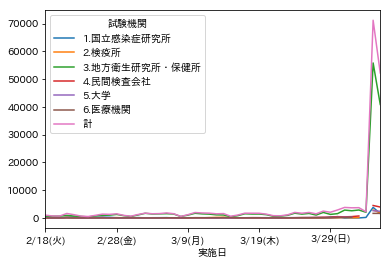

In [22]:
data.T.plot()

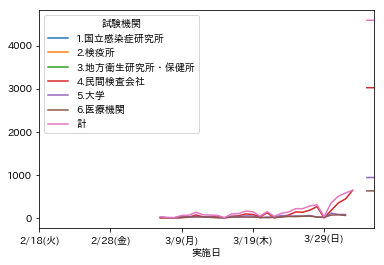

In [23]:
ctr_association = TestNumberWithAssociation(
        URL_OF_PDF_FILE_WITH_PCR_TEST_NUMBER_WITH_ASSOCIATION_IN_JAPAN
)
data2 = ctr_association.get_data()[1]
data2.T.plot()